# PyPSA-Earth Sample Network Analysis

This notebook is an introduction to the analysis of unsolved and solved networks generated by PyPSA-Earth tutorial.

## Folder structure and loading networks

Building the folder structure is the first step:

- Start by creating a folder named pypsa-earth-project by executing the following line in the terminal:
    ```
        $ mkdir pypsa-earth-project
    ```
- Change the current directory to that folder:
    ```
        $ cd pypsa-earth-project
    ```
- Clone pypsa-earth repository from GitHub into the folder:
    ```
        $ git clone https://github.com/pypsa-meets-earth/pypsa-earth.git 
    ```
- Finally Clone documentation repository into the folder:
    ```
        $ git clone https://github.com/pypsa-meets-earth/documentation.git
    ```

The following script imports required modules to run the network analysis:

In [1]:
import os
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import sys
import pandas as pd
from zipfile import ZipFile
import sys

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root, progress_retrieve

sets_path_to_root("documentation")


This is the repository path:  ~/_github_/documentation
Had to go 1 folder(s) up.


Download network files:

A pre-run has been performed for the tutorial case and the solved/unsolved networks can be downloaded from zenodo using the following script:

In [2]:
#if os.path.exists(os.getcwd() + "/networks"):
#    print("This file already exists")
#else:
#    file_path = os.path.join(os.getcwd(), "tempfile.zip")   
#    url = "https://zenodo.org/record/7265586/files/networks.zip?download=1"
#    progress_retrieve(url, file_path)
#    with ZipFile(file_path, "r") as zipObj:
#        zipObj.extractall(path=os.getcwd()) # Extract all the contents of zip file in current directory
#    os.remove(file_path)

Load networks:

The following table provides a summary of the output networks from the sequencing scripts used in this tutorial case:

| Script                | Network file                             |
| -----------           | -----------                              |
| base_network          | base.nc                                  |
| add_electricity       | elec.nc                                  |
| simplify_network      | elec_s.nc                                |
| cluster_network       | elec_s_6.nc                              |
| add_exta_components   | elec_s_6_ec.nc                           |
| prepare_netwrok       | elec_s_6_ec_lcopt_Co2L-4H.nc (unsolved)  | 
| solve_all_networks    | elec_s_6_ec_lcopt_Co2L-4H.nc (solved)    | 

each of which can be loaded and analysed:

In [3]:
#add_electricity_network = os.getcwd() + '/networks/unsolved/elec.nc'
#clustered_network = os.getcwd() + '/networks/unsolved/elec_s_6.nc'
# n_add_el = pypsa.Network(add_electricity_network)
# n_cluster = pypsa.Network(clustered_network)
#solved_network = os.getcwd() + "/networks/solved/elec_s_6_ec_lcopt_Co2L-4H.nc"

solved_network = "~/_github_/pypsa-africa-aux/_world_testing_data_/CL_test_1/results/networks/elec_s_10_ec_lcopt_Co2L0.05-3H.nc"
n_solve = pypsa.Network(solved_network)


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 20, 0].

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L0.05-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
n = n_solve

Plot network nodes and lines by simply executing:

(<matplotlib.collections.PatchCollection at 0x179477820>,
 <matplotlib.collections.LineCollection at 0x17964cf70>)

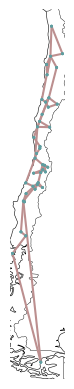

In [5]:
n.plot()

## Network components

PyPSA has a group of components tha are already built-in such as generators, loads, lines, etc.. While allowing the user to override this and build their custom components, read more at [PyPSA Design](https://pypsa.readthedocs.io/en/latest/components.html#groups-of-components). 

The built-in components can be static or time-varying. Time-varying components can be obtained by adding `_t` to the component:

- network.generator     &rarr; static component
- network.generator_t   &rarr; time-varying component

A list of the buit-in PyPSA components and their associated attributes can be found at [PyPSA Components](https://pypsa.readthedocs.io/en/latest/components.html).

For example, the [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) component has an attribute of `p_nom_opt`, which represent the optimised nominal power. This output can be obtained by the following line:


In [6]:
n.generators.p_nom_opt.head(2) # "head" returns the first 2 rows

Generator
CL0 0 CCGT      10.8000
CL0 0 OCGT    1699.3458
Name: p_nom_opt, dtype: float64

To get the number of components and snapshots in the network: 

In [7]:
n.statistics._parent

PyPSA Network
Components:
 - Bus: 120
 - Carrier: 18
 - Generator: 159
 - GlobalConstraint: 1
 - Line: 55
 - Link: 160
 - Load: 40
 - StorageUnit: 4
 - Store: 80
Snapshots: 56

## Network analysis

The following network analysis scripts were inspired by the work of Fabian Neumann in this [video](https://www.youtube.com/watch?v=mAwhQnNRIvs&t=734s) with PyPSA-EUR, which has a similar model structure as PyPSA-Earth

## Static components data


Static data for various components such as generators, lines and storage units can be obtained directly through the following lines, with the ability to manipulate the data:

In [8]:
n.lines.head(2)

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,s_nom_extendable,s_nom_min,...,s_nom_max,build_year,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,CL0 0,CL0 3,2.578947,432.277848,Al/St 240/40 4-bundle 380.0,0.7,4379.317262,16469.073936,True,4379.317262,...,inf,0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,CL0 0,CL0 8,3.736842,125.547637,Al/St 240/40 4-bundle 380.0,0.7,6345.541339,4783.597766,True,6345.541339,...,inf,0,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [9]:
n.generators.head(2)

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
CL0 0 CCGT,inf,0.0,10.800000,84469.122809,0.50,10.800000,47.209992,False,CL0 0,CCGT,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
CL0 0 OCGT,inf,0.0,1699.345825,47234.561404,0.39,1699.345825,58.393713,True,CL0 0,OCGT,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [10]:
n.storage_units.head(2)

,bus,cyclic_state_of_charge,efficiency_store,p_min_pu,efficiency_dispatch,max_hours,marginal_cost,p_nom,carrier,p_nom_opt,...,sign,capital_cost,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
CL0 2 hydro,CL0 2,True,0.0,0.0,0.9,6.0,0.019336,1857.038217,hydro,1857.038217,...,1.0,0.0,0,inf,0.0,False,NaN,True,0.0,0.0
CL0 4 hydro,CL0 4,True,0.0,0.0,0.9,6.0,0.020660,1155.984076,hydro,1155.984076,...,1.0,0.0,0,inf,0.0,False,NaN,True,0.0,0.0


In [11]:
n.stores.head(2)

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,marginal_cost,e_nom_opt,type,e_nom,e_nom_min,...,e_max_pu,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,standing_loss,build_year,lifetime
Store,,,,,,,,,,,,,,,,,,,,,
CL0 0 H2,CL0 0 H2,H2,True,True,796.283619,0.010643,0.0,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
CL0 1 H2,CL0 1 H2,H2,True,True,796.283619,0.010464,0.0,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf


In [12]:
n.loads.head(2) # no results because loads are mostly time dependent

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
CL0 0,CL0 0,,,0.0,0.0,-1.0
CL0 1,CL0 1,,,0.0,0.0,-1.0


## Time-varying components data

PyPSA-Earth has several components to refelct time-varying behaviour of energy systems, including loads, generators, storage units, etc..

Excute the following line to get results of time-varying load:

In [13]:
n.loads_t.p_set.head(2)

Load,CL0 0,CL0 1,CL0 2,CL0 3,CL0 4,CL0 5,CL0 6,CL0 7,CL0 8,CL0 9,...,CL28 0,CL29 0,CL3 0,CL30 0,CL4 0,CL5 0,CL6 0,CL7 0,CL8 0,CL9 0
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,640.829861,415.815332,1232.858994,331.420102,463.634034,324.232408,644.950278,371.835944,4761.617311,278.698180,...,117.311151,19.081132,5.799662,107.320186,16.297385,41.042576,240.974685,22.690558,5.468977,43.605164
2013-01-01 03:00:00,537.158648,348.546182,1033.411379,277.804118,388.628942,271.779223,540.612478,311.681626,3991.299518,233.611363,...,98.332963,15.994253,4.861413,89.958302,13.660851,34.402852,201.990643,19.019759,4.584225,36.550873


Aggregate time-varying loads along columns to get aggregated time series for the whole system, and plot them using the following line

<AxesSubplot: xlabel='snapshot', ylabel='MW'>

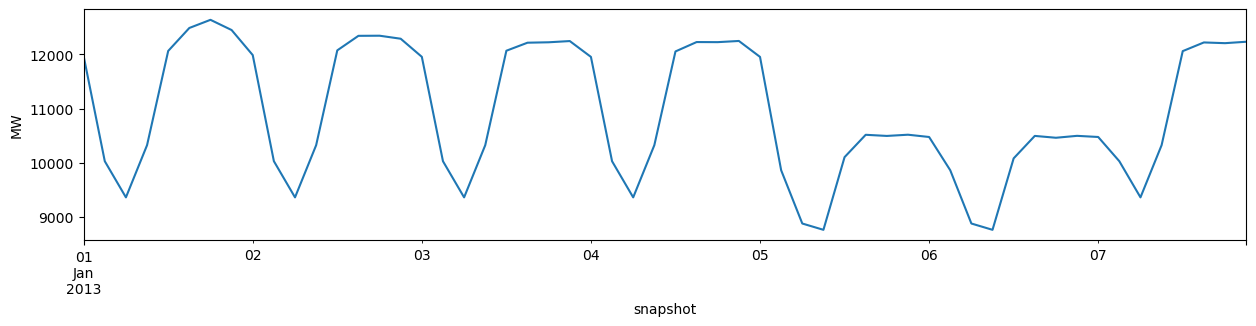

In [14]:
n.loads_t.p_set.sum(axis=1).plot(figsize=(15,3), ylabel="MW")

Time-varying capacity factors for renewable generators

In [15]:
n.generators_t.p_max_pu.head(2)

Generator,CL0 0 onwind,CL0 0 solar,CL0 1 onwind,CL0 1 solar,CL0 2 onwind,CL0 2 ror,CL0 2 solar,CL0 3 onwind,CL0 3 ror,CL0 3 solar,...,CL6 0 onwind,CL6 0 ror,CL6 0 solar,CL7 0 onwind,CL7 0 solar,CL8 0 onwind,CL8 0 solar,CL9 0 onwind,CL9 0 ror,CL9 0 solar
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.107657,0.0,0.043653,0.0,0.422547,0.0,0.0,0.148779,0.0,0.0,...,0.121620,0.0,0.0,0.0,0.0,0.332112,0.0,0.051527,0.0,0.0
2013-01-01 03:00:00,0.075005,0.0,0.000000,0.0,0.363936,0.0,0.0,0.123168,0.0,0.0,...,0.111772,0.0,0.0,0.0,0.0,0.288072,0.0,0.043437,0.0,0.0


Specify a particular time period and generator location for the capacity factor:

<AxesSubplot: xlabel='snapshot'>

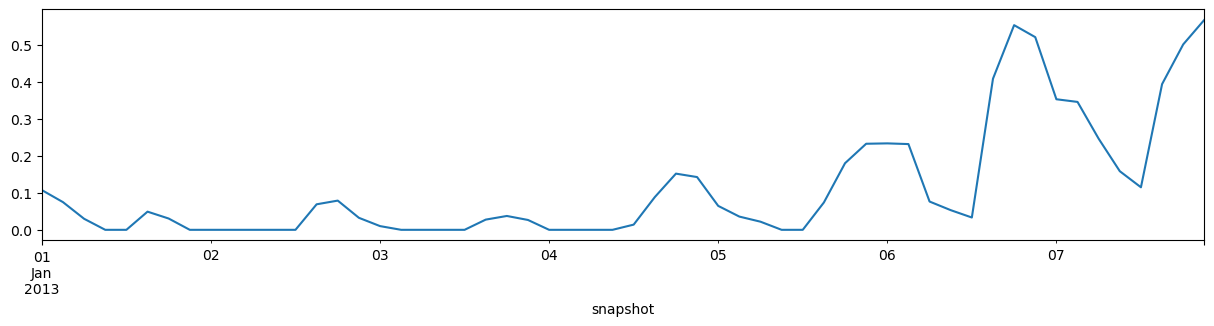

In [17]:
n.generators_t.p_max_pu.loc["2013-01", "CL0 0 onwind"].plot(figsize=(15,3))

<AxesSubplot: xlabel='snapshot'>

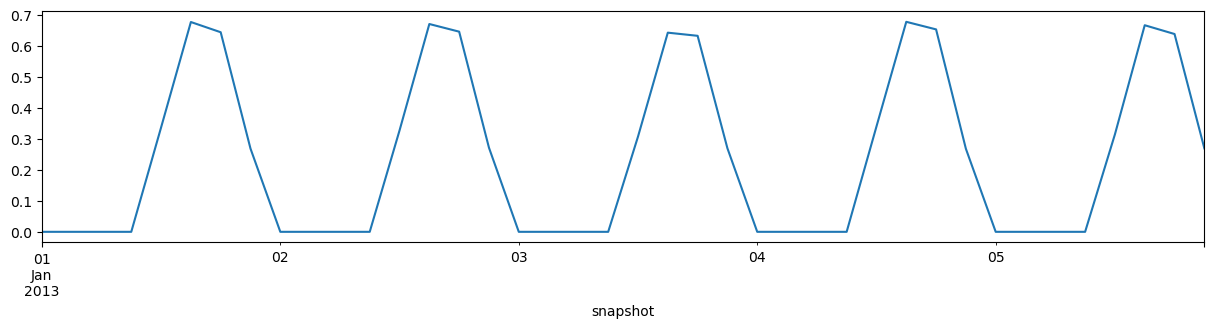

In [18]:
n.generators_t.p_max_pu.loc["2013-01-01":"2013-01-05", "CL0 0 solar"].plot(figsize=(15,3))

## Solved network outputs

Aftwer solving the network, optimized outputs and system costs can be obtained and analysed

Total annual system costs in billion euros per year:

In [19]:
n.objective / 1e9

3.1758482878154966

Transmission lines Expansion:

In [20]:
(n.lines.s_nom_opt - n.lines.s_nom).head(5) # optimized line capacity compared to original capacity

Line
1       0.000038
2    1527.586161
3      -0.000035
4      -0.000023
5      -0.000035
dtype: float64

Optimised generator capacity:

In [21]:
n.generators.groupby("carrier").p_nom_opt.sum() / 1e3 # GW

# Note: the "load" in the generators represents the Demand Side Response to match the power demand with the supply.

carrier
CCGT      7.195769e-02
OCGT      4.189015e+00
coal      6.130854e+00
load      4.000000e+07
oil       2.247103e+00
onwind    3.093808e+00
ror       2.437930e+00
solar     1.197297e+01
Name: p_nom_opt, dtype: float64

Optimised storage capacity:

In [22]:
n.storage_units.groupby("carrier").p_nom_opt.sum() / 1e3 # GW

carrier
hydro    3.419182
Name: p_nom_opt, dtype: float64

Average daily state of charge for storage units:

<AxesSubplot: xlabel='snapshot'>

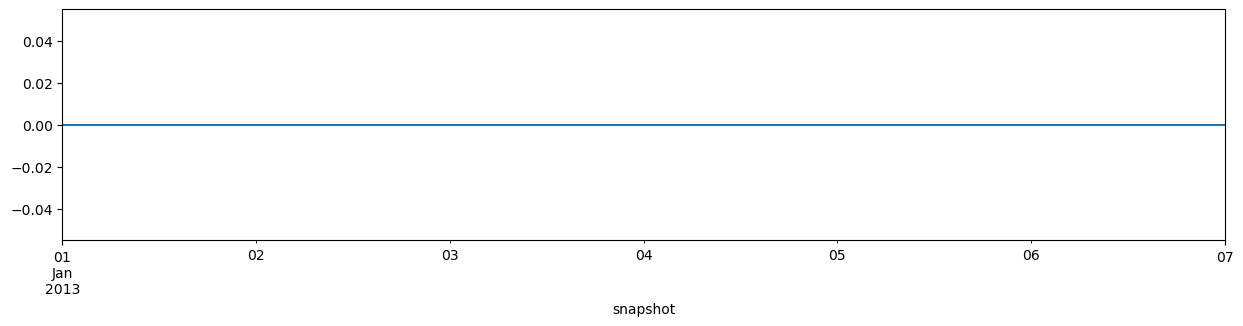

In [23]:
(n.storage_units_t.state_of_charge.sum(axis=1).resample('D').mean() / 1e6).plot(figsize=(15,3)) #TWh

State of charge for a period of time to a particular storage technology:

/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/ipykernel_24301/3201421919.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  (n.storage_units_t.state_of_charge["2013-01"].filter(like="hydro", axis=1).sum(axis=1) / 1e6).plot(figsize=(15,3)) #TWh


<AxesSubplot: xlabel='snapshot'>

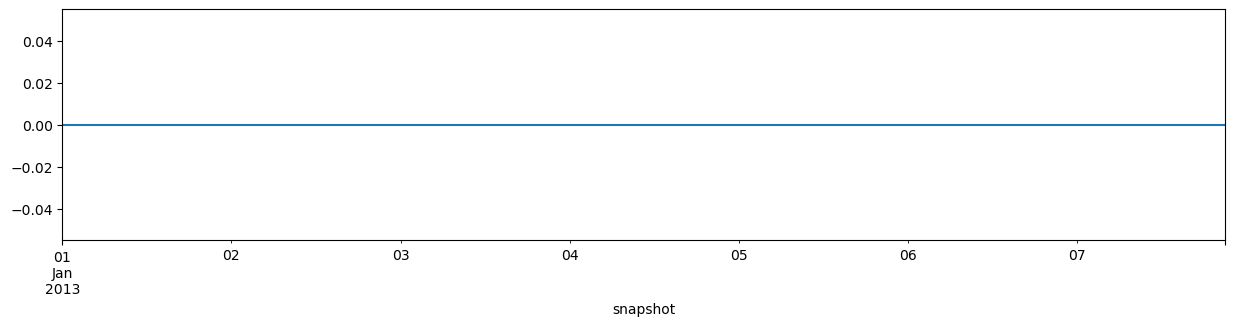

In [24]:
(n.storage_units_t.state_of_charge["2013-01"].filter(like="hydro", axis=1).sum(axis=1) / 1e6).plot(figsize=(15,3)) #TWh

## Network Statistics

It is possible to get direct analysis values of the network and plot them, including Capacity Factor, Capital Expenditure, Curtailment, Installed Capacity, Operational Expenditure, Optimal Capacity, Revenue, Supply and Withdrawal

In [25]:
n.statistics()

# Note: the "load" in the generators represents the Demand Side Response to match the power demand with the supply.

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Coal                   7.809959e-01         7.511023e+08   
            Combined-Cycle Gas     6.037333e-01         6.078203e+06   
            Oil                    1.834781e-02         8.591698e+07   
            Onshore Wind           5.528039e-01         3.381395e+08   
            Open-Cycle Gas         3.076336e-01         1.978663e+08   
            Run of River           0.000000e+00         6.605346e+08   
            Solar                  2.560249e-01         6.592804e+08   
            load                   1.592182e-21         0.000000e+00   
Line        AC                     3.114690e-01         9.320073e+08   
Link        H2 electrolysis       -1.585896e-01        -2.355887e-05   
            H2 fuel cell          -3.097037e-01        -1.109224e-05   
            battery charger                 inf         0.000000e+00   
            battery discharger    -7.149135e+00         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam                 NaN         0.000000e+00   
Store       Battery Storage       -3.006144e+00        -9.823726e-07   
            Hydrogen Storage       5.156038e-01         4.304015e-05   

                                Curtailment  Installed Capacity  \
            carrier                                               
Generator   Coal                   0.000000        6.130854e+03   
            Combined-Cycle Gas     0.000000        7.195769e+01   
            Oil                    0.000000        2.247103e+03   
            Onshore Wind          -0.000299        0.000000e+00   
            Open-Cycle Gas         0.000000        3.794399e+03   
            Run of River           0.000000        2.437930e+03   
            Solar                 -0.000835        0.000000e+00   
            load                   0.000000        4.000000e+10   
Line        AC                          NaN        4.607221e+04   
Link        H2 electrolysis             NaN        0.000000e+00   
            H2 fuel cell                NaN        0.000000e+00   
            battery charger             NaN        0.000000e+00   
            battery discharger          NaN        0.000000e+00   
Load        -                           NaN                 NaN   
StorageUnit Reservoir & Dam        0.000000        3.419182e+03   
Store       Battery Storage             NaN        0.000000e+00   
            Hydrogen Storage            NaN        0.000000e+00   

                                Operational Expenditure  Optimal Capacity  \
            carrier                                                         
Generator   Coal                           1.154603e+05      6.130854e+03   
            Combined-Cycle Gas             2.050957e+03      7.195769e+01   
            Oil                            5.369572e+03      2.247103e+03   
            Onshore Wind                   4.346034e+01      3.093808e+03   
            Open-Cycle Gas                 7.525148e+04      4.189015e+03   
            Run of River                   0.000000e+00      2.437930e+03   
            Solar                          6.063159e+01      1.197297e+04   
            load                          -6.429776e-11      4.000000e+10   
Line        AC                                      NaN      7.949266e+04   
Link        H2 electrolysis                0.000000e+00     -4.828190e-10   
            H2 fuel cell                   0.000000e+00     -4.535195e-10   
            battery charger                0.000000e+00      0.000000e+00   
            battery discharger             0.000000e+00     -2.615531e-13   
Load        -                                       NaN               NaN   
StorageUnit Reservoir & Dam                0.000000e+00      3.419182e+03   
Store       Battery Storage               -1.696490e-24     -6.187050e-11   
   

Plotting the capital expendture for various generators:

<AxesSubplot: xlabel='carrier', ylabel='Euros'>

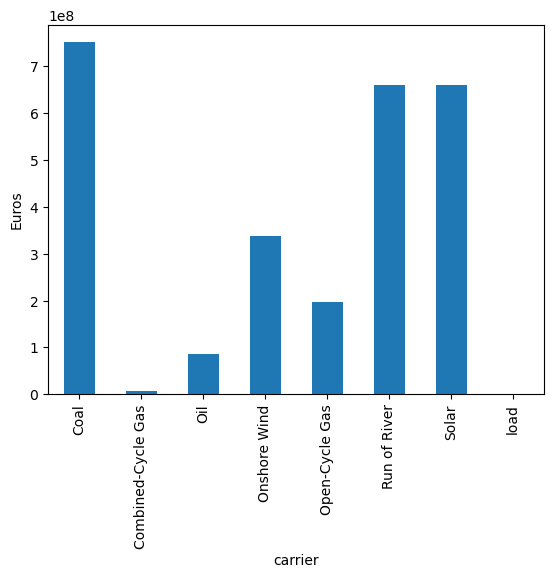

In [26]:
n.statistics()["Capital Expenditure"].loc["Generator"].plot.bar(ylabel="Euros")

## Sample plots of networks and outputs

Plot lines and their loading:

(-73.96607, -68.51073000000001, -54.821570217391304, -18.154825434782612)

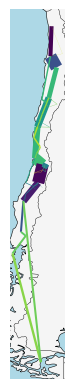

In [27]:
loading = (n.lines_t.p0.abs().mean().sort_index() / (n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)
# Example types of projections: PlateCarree, Mercator, Orthographic
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax,
    bus_colors='gray',
    branch_components=["Line"],
    line_widths=n.lines.s_nom_opt/1e3,
    line_colors=loading,
    line_cmap=plt.cm.viridis,
    color_geomap=True,
    bus_sizes=0
)
ax.axis('off')

Plot hourly dispatch in a particular period of time:

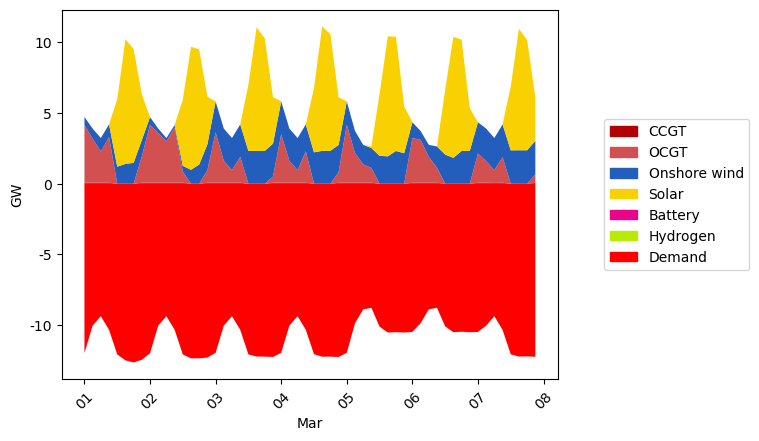

In [28]:
first_date = "2013-01-01"
second_date = "2013-01-07"
CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

fig, ax=plt.subplots()
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
A = plt.stackplot(CCGT.index,CCGT,OCGT,Onwind, pbattery,solar, H2, colors=['#b20101','#d35050','#235ebc','#ea048a','#f9d002','#b8ea04'], zorder = 3)
plt.stackplot(CCGT.index,demand,nbattery, colors=['#FF0000','#ea048a'], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Mar')

CCGT_patch = mpatches.Patch(color='#b20101', label ='CCGT')
OCGT_patch = mpatches.Patch(color='#d35050', label ='OCGT')
wind_patch = mpatches.Patch(color='#235ebc', label ='Onshore wind')
solar_patch = mpatches.Patch(color='#f9d002', label ='Solar')
H2_patch = mpatches.Patch(color='#b8ea04', label ='Hydrogen')
battery_patch = mpatches.Patch(color='#ea048a', label ='Battery')
load_patch = mpatches.Patch(color='#FF0000', label ='Demand')
handles=[CCGT_patch,OCGT_patch,wind_patch,solar_patch,battery_patch,H2_patch,load_patch]
ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.show()
#fig.savefig("path")

## Additional analysis and validation

The following notebooks provide additional analysis, plots and validation of the networks:

[Plot osm network](./0_build_osm_network_plot.ipynb)

[Explore network](./0_network_exploration.ipynb)

[Check outputs of build_shapes script](./0build_shapes.ipynb)

[Compare shapes for countries](./0shape_comparison.ipynb)

[Check base network](./base_network.ipynb)

[Check outputs of add_electricity script](./add_electricity.ipynb)

[Check outputs of augmented_line_connections script](./augmented_line_connections.ipynb)

[Test the built cutouts](./build_cutout.ipynb)

[Test the renewable profiles](./build_renewable_profiles.ipynb)

[Check land use availability](./land_use_availability.ipynb)

[Check network characteristics before solving](./network_characteristics_before_solve.ipynb)

[Some nice plots for presentations](./nice_plotting_for_presentations.ipynb)

[Download OSM and make adjustments](./openstreetmap_download_and_adjustments.ipynb)

[Visualise clustering](./visualise_clustering.ipynb)

The following notebooks could be used for validation:

[Capacity validation](./capacity_validation.ipynb)

[Demand validation](./demand_validation.ipynb)

[Hydro generation validation](./hydro_generation_validation.ipynb)

[Network validation](./network_validation.ipynb)

[Renewable potential validation](./renewable_potential_validation.ipynb)


